In [1]:
import sys
sys.path.append('../../../')
import torch
from matplotlib import pyplot as plt
from tifffile import imread, imwrite
from sklearn.cluster import KMeans
import numpy as np
from glob import glob
from tqdm import tqdm

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [3]:
path="/group/jug/Sheida/pancreatic beta cells/download/high_c1/"
patch_size = 64
model = torch.load("/home/sheida.rahnamai/GIT/HDN/examples/Pixel_Noise/Convallaria/Trained_model/model/Contrastive_MAE_best_vae.net")
model.mode_pred=True
model.eval()
model.to(device)

LadderVAE(
  (first_bottom_up): Sequential(
    (0): Conv2d(1, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ELU(alpha=1.0)
    (2): BottomUpDeterministicResBlock(
      (res): ResidualBlock(
        (block): Sequential(
          (0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (1): ELU(alpha=1.0)
          (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (3): Dropout2d(p=0.2, inplace=False)
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (5): ELU(alpha=1.0)
          (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (7): Dropout2d(p=0.2, inplace=False)
        )
      )
    )
  )
  (top_down_layers): ModuleList(
    (0-3): 4 x TopDownLayer(
      (deterministic_block): Sequential(
        (0): TopDownDeterministicResBlock(
          (pre_conv): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), 

In [10]:
def clustering(mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(160, -1).T
    K_CENTRE = 20
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

In [5]:
def get_normalized_tensor(img,model,device):
    '''
    Normalizes tensor with mean and std.
    Parameters
    ----------
    img: array
        Image.
    model: Hierarchical DivNoising model
    device: GPU device.
    '''
    test_images = torch.from_numpy(img.copy()).to(device)
    data_mean = model.data_mean
    data_std = model.data_std
    test_images = (test_images-data_mean)/data_std
    return test_images

In [6]:
def make_tiled(img):
    out = np.zeros([img.shape[0]+61, img.shape[1]+60])
    # make mirror margin of 2d image
    for i in range(30):
        out[i,30:30+img.shape[1]] = img[30-i-1,:]
        out[30:30+img.shape[0],30:30+img.shape[1]] = img
        out[30+img.shape[0]+i,30:30+img.shape[1]] = img[img.shape[0]-i-1,:]
    out[img.shape[0]+60,30:30+img.shape[1]] = img[img.shape[0]-31,:]
    for i in range(30):
        out[:,i] = out[:,60-i-1]
        out[:, 30+img.shape[1]+i] = out[:, 30+img.shape[1]-i-1]
    return out
    

In [16]:
img = imread(path+"data/test/high_c1_source_31.tif")
tiled = make_tiled(img)
img_height,img_width = 700,760
img = get_normalized_tensor(tiled,model,device)
output = np.zeros((160, 700, 760))
for i in tqdm(range(0, img_height, 4)):
    for j in range(0, img_width, 4):
        img_t = img[i:i+64,j:j+64]
        image_sample = img_t.view(1,1,64,64)
        image_sample = image_sample.to(device=device, dtype=torch.float)
        with torch.no_grad():
            sample = model(image_sample, image_sample)
            mus = sample['mu']
            output[:32,i:i+4,j:j+4] = sample['mu'][0][0].cpu().numpy()[:,14:18,14:18]
            output[32:64,i:i+4,j:j+4] = sample['mu'][1][0].cpu().numpy()[:,6:10,6:10]
            output[64:96,i:i+4,j:j+4] = sample['mu'][2][0].cpu().numpy()[:,2:6,2:6]
            output[96:128,i:i+4,j:j+4] = sample['mu'][3][0].cpu().numpy()
            output[128:160,i:i+4,j:j+4] = sample['mu'][4][0].cpu().numpy().repeat(2,axis=1).repeat(2,axis=2)


 91%|█████████▏| 160/175 [14:54<01:23,  5.59s/it]


ValueError: Expected parameter scale (Tensor of shape (1, 32, 32, 32)) of distribution Normal(loc: torch.Size([1, 32, 32, 32]), scale: torch.Size([1, 32, 32, 32])) to satisfy the constraint GreaterThan(lower_bound=0.0), but found invalid values:
tensor([[[[9.7805e-01, 1.0030e+00, 1.1499e+00,  ..., 1.0555e+00,
           1.0888e+00, 1.0649e+00],
          [9.4577e-01, 9.5598e-01, 8.9095e-01,  ..., 1.1694e+00,
           1.1691e+00, 1.1303e+00],
          [8.6623e-01, 7.7816e-01, 9.1913e-01,  ..., 1.1807e+00,
           1.2603e+00, 1.1187e+00],
          ...,
          [1.0736e+00, 6.9394e+00, 1.5377e-01,  ..., 3.8091e+00,
           1.1827e+00, 1.5750e+00],
          [1.3241e+00, 9.9653e-01, 3.7712e-01,  ..., 2.2537e+00,
           1.4879e+00, 1.3395e+00],
          [5.4251e-01, 1.5164e-01, 7.6205e-02,  ..., 1.1724e+00,
           1.3459e+00, 1.1179e+00]],

         [[9.2396e-01, 1.1589e+00, 8.8137e-01,  ..., 1.1496e+00,
           9.0532e-01, 1.0429e+00],
          [1.0074e+00, 9.8323e-01, 1.1394e+00,  ..., 1.0530e+00,
           1.0146e+00, 1.0637e+00],
          [8.3740e-01, 1.2339e+00, 7.2852e-01,  ..., 1.0251e+00,
           8.2014e-01, 9.9594e-01],
          ...,
          [1.3975e+00, 5.5641e-02, 1.1085e-04,  ..., 2.2116e-02,
           4.6429e-02, 4.5149e-01],
          [6.2922e-01, 1.1057e-01, 1.1596e-03,  ..., 1.2885e-02,
           2.9917e-01, 6.4132e-01],
          [4.9995e-01, 1.1943e-01, 1.6591e-01,  ..., 1.4182e-01,
           3.7398e-01, 4.3598e-01]],

         [[9.2155e-01, 1.0462e+00, 1.0791e+00,  ..., 1.0675e+00,
           1.0081e+00, 1.0143e+00],
          [1.1826e+00, 1.1355e+00, 1.3433e+00,  ..., 1.2104e+00,
           1.0902e+00, 1.1057e+00],
          [1.1283e+00, 1.2420e+00, 1.0261e+00,  ..., 1.8442e+00,
           1.3698e+00, 1.0696e+00],
          ...,
          [1.6969e+00, 2.9650e-01, 1.4132e+00,  ..., 5.6012e+00,
           3.8623e+00, 1.6158e+00],
          [2.5158e+00, 5.1187e+00, 3.4867e+00,  ..., 3.6326e+00,
           1.1682e+00, 1.3180e+00],
          [8.3598e-01, 4.6886e-01, 3.0955e+00,  ..., 1.0682e+00,
           1.7571e+00, 1.2707e+00]],

         ...,

         [[9.7128e-01, 1.0336e+00, 1.0248e+00,  ..., 9.6947e-01,
           9.6309e-01, 9.8474e-01],
          [1.1243e+00, 9.8257e-01, 1.1808e+00,  ..., 8.9388e-01,
           1.1368e+00, 1.1078e+00],
          [9.6913e-01, 1.0282e+00, 8.6580e-01,  ..., 8.6275e-01,
           8.3486e-01, 1.0452e+00],
          ...,
          [1.6352e+00, 2.6017e-01, 1.8774e-01,  ..., 1.2643e+00,
           1.4332e+00, 1.1940e+00],
          [4.2094e-01, 2.3652e-01, 2.3415e+00,  ..., 3.3429e-01,
           1.0119e+00, 1.1386e+00],
          [8.7081e-01, 1.4027e+00, 2.5053e+00,  ..., 1.1706e+00,
           7.0206e-01, 1.2566e+00]],

         [[9.8869e-01, 8.9273e-01, 7.6956e-01,  ..., 9.3466e-01,
           9.5314e-01, 9.9534e-01],
          [1.0283e+00, 8.6742e-01, 1.0323e+00,  ..., 9.5825e-01,
           1.0340e+00, 9.6933e-01],
          [8.4859e-01, 9.8660e-01, 7.4711e-01,  ..., 1.1386e+00,
           1.0203e+00, 1.0449e+00],
          ...,
          [1.8893e+00, 7.2974e-02, 2.7911e-04,  ..., 7.7587e-02,
           4.4184e-01, 1.1035e+00],
          [1.1283e+00, 2.9033e+00, 5.3872e-02,  ..., 1.5481e+00,
           1.1989e+00, 1.3475e+00],
          [1.3408e+00, 1.7411e+00, 3.2324e+00,  ..., 2.0133e+00,
           5.9744e-01, 1.1421e+00]],

         [[9.5995e-01, 1.0347e+00, 9.4255e-01,  ..., 1.2112e+00,
           1.2104e+00, 1.0760e+00],
          [1.0284e+00, 1.2822e+00, 1.0986e+00,  ..., 1.4070e+00,
           1.3720e+00, 1.1187e+00],
          [9.0860e-01, 1.2835e+00, 9.9262e-01,  ..., 1.6251e+00,
           1.2392e+00, 1.1358e+00],
          ...,
          [1.0750e+00, 2.1173e+01, 2.6197e+00,  ..., 3.0375e+01,
           1.5193e+01, 2.1439e+00],
          [5.9974e-01, 4.4240e+00, 3.7656e+01,  ..., 6.2753e+01,
           4.8645e+00, 1.9910e+00],
          [9.1267e-01, 1.0059e+00, 2.3920e+00,  ..., 2.5026e+00,
           1.6248e+00, 1.3250e+00]]]], device='cuda:0')

In [ ]:
clusters = clustering(output)

In [ ]:
imwrite(path+"kl_as_cl_661_20cluster.tif", clusters.reshape(700, 760))

In [9]:
def clustering_down_scale(index, mu):
    slice_features_mu = mu.astype(float)
    feature_flatten_mu = slice_features_mu.reshape(32, -1).T
    K_CENTRE = 8
    kmeans_mu = KMeans(
        n_clusters=K_CENTRE, init='k-means++', n_init=10,
        max_iter=1000, random_state=777
    )
    kmeans_mu.fit(feature_flatten_mu)
    labels_mu = kmeans_mu.predict(feature_flatten_mu)
    return labels_mu

(160, 768, 704)
(32, 352, 384)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/data/test/high_c1_source_31.tif


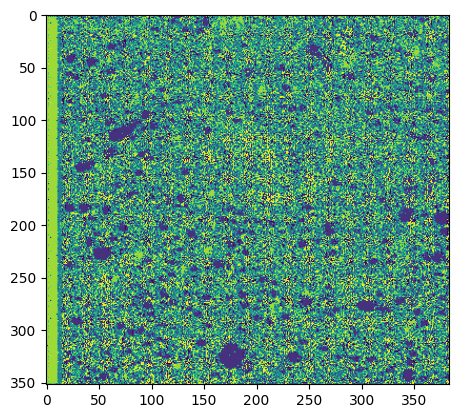

(32, 176, 192)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/data/test/high_c1_source_31.tif


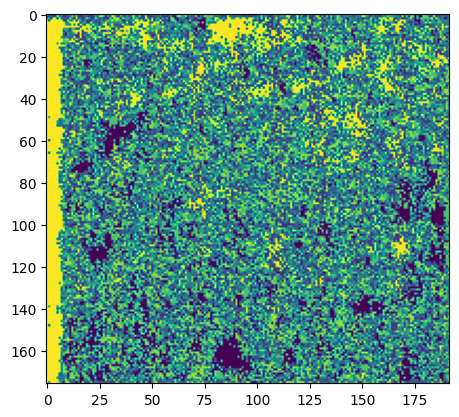

(32, 88, 96)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/data/test/high_c1_source_31.tif


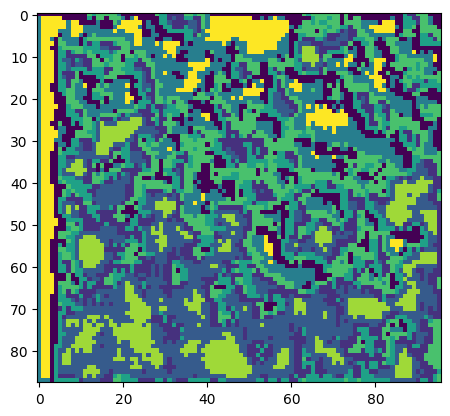

(32, 44, 48)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/data/test/high_c1_source_31.tif


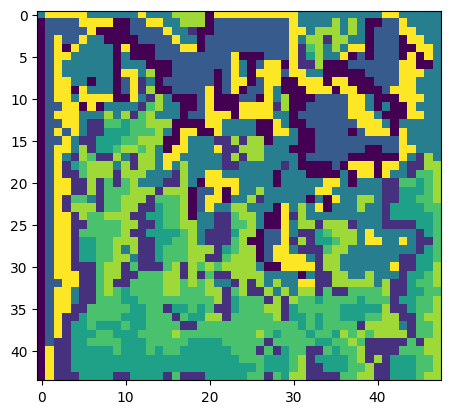

(32, 22, 24)
/group/jug/Sheida/pancreatic beta cells/download/high_c1/data/test/high_c1_source_31.tif


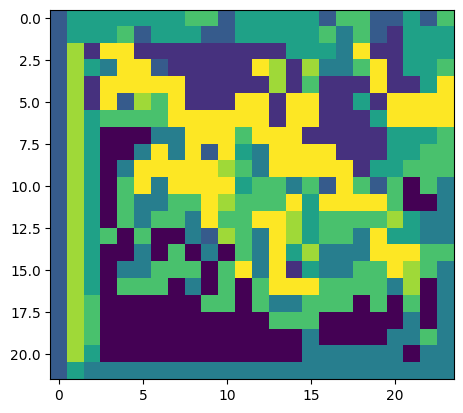

In [14]:
files = glob(path+"data/test/high_c1_source_31.tif")
img_height,img_width = 699, 760
for i in files:
    img = imread(i)
    img_t = get_normalized_tensor(img,model,device)
    image_sample = img_t.view(1,1,img_height,img_width)
    image_sample = image_sample.to(device=device, dtype=torch.float)
    with torch.no_grad():
        sample = model(image_sample, image_sample)
        mus = sample['mu']
        output = np.zeros((160, 768, 704))

        print(output.shape)

        for idx in range(len(sample['mu'])):
            mu = sample['mu'][idx][0].cpu().numpy()
            print(mu.shape)
            output = clustering_down_scale(idx, mu)
            print(i)
            # imwrite(path+str(idx)+".tif", output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.imshow(output.reshape(22*(2**(4-idx)), 24*(2**(4-idx))))
            plt.show()

In [20]:
import torch.nn.functional as F
import torch.nn as nn
kl_loss = nn.KLDivLoss(reduction="batchmean")
# input should be a distribution in the log space
input = F.log_softmax(torch.randn(3, 5, requires_grad=True), dim=1)
# Sample a batch of distributions. Usually this would come from the dataset
target = F.softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, target)

kl_loss = nn.KLDivLoss(reduction="batchmean", log_target=True)
log_target = F.log_softmax(torch.rand(3, 5), dim=1)
output = kl_loss(input, log_target)
print("input: ",input,"\nlog target: ",log_target,"\noutput: ",output)

input:  tensor([[-3.2952, -1.7060, -0.9912, -2.7446, -1.0615],
        [-1.6900, -1.5380, -3.2578, -0.6780, -2.9077],
        [-1.8940, -1.7623, -3.3684, -1.7628, -0.7510]],
       grad_fn=<LogSoftmaxBackward0>) 
log target:  tensor([[-1.3486, -1.9056, -1.2907, -2.0687, -1.6595],
        [-1.4861, -1.8527, -1.2753, -1.7434, -1.8161],
        [-1.1050, -2.0313, -2.0175, -1.7511, -1.4651]]) 
output:  tensor(0.3831, grad_fn=<DivBackward0>)
